In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import time

In [2]:
# reading a map
def get_map(path, nside):
    map = hp.read_map(path)
    map = hp.ud_grade(map,nside_out=nside)
    map[np.isnan(map)==True]=0.
    return map

#reading a weight
def get_weight(path,nside):
    map = hp.read_map(path)
    weight = np.zeros(hp.nside2npix(hp.get_nside(map)))
    weight[map>0.] = 1.
    weight = hp.ud_grade(weight,nside_out=nside)
    weight[weight>0.] = 1.
    return weight

# mean subtraction
def get_map_zero_mean(map, weight):
    norm = sum(weight*map)/sum(weight)
    map_zero_mean = weight*map/norm - weight
    return map_zero_mean

#corr. calculator
def get_twopt_corr(theta_bins, map1, map2, weight, nside):
    pixel_indices = np.where(weight>0.)[0]
    
    delta1 = get_map_zero_mean(map1,weight)
    delta2 = get_map_zero_mean(map2,weight)
    
    n_points = len(pixel_indices)
    pixel_counts = np.zeros(nbins)
    correlation_counts = np.zeros(nbins)
    for i in range(n_points):
        pixel_center = pixel_indices[i]
        neighbors = hp.query_disc(nside, hp.pix2vec(nside, pixel_center), np.pi/90.)  # Query the disc around the current pixel
        for neighbor in neighbors:
            sep = hp.rotator.angdist(hp.pix2ang(nside, pixel_center), hp.pix2ang(nside, neighbor))  # Calculate angular separation
            bin_index = np.searchsorted(theta_bins, sep)
            pixel_counts[bin_index - 1] += 1
            
            if weight[neighbor]==1. :
                correlation_counts[bin_index - 1] += delta1[pixel_center]*delta2[neighbor]  # Increment the count in the corresponding bin

    # Normalize the correlation function
    print(pixel_counts)
    print(correlation_counts)
    # Normalize the correlation function
    correlation_function = correlation_counts/pixel_counts
    
    return correlation_function

In [3]:
#Healpixconfig.
nside = 256
npix = hp.nside2npix(nside)
theta_pix = np.sqrt(hp.nside2pixarea(nside,degrees=True))
print(theta_pix)

# Angular binning for correlation function
nbins = 20
theta_bins = np.linspace(theta_pix*np.pi/180, np.pi/90., nbins + 1)
print(theta_bins)

0.2290324274544937
[0.00399737 0.00554283 0.00708829 0.00863375 0.01017921 0.01172467
 0.01327013 0.0148156  0.01636106 0.01790652 0.01945198 0.02099744
 0.0225429  0.02408836 0.02563382 0.02717928 0.02872474 0.0302702
 0.03181566 0.03336112 0.03490659]


In [4]:
# get maps
root = '../../fits/HSC_ACT/goldrush'
maps = {'LBGs': get_map(root+'/cmap_SigmaClippedAround_SNcutted_gri_W_W02_i_fluxcut25p5_nside%d.fits'%nside,nside),
             'stars': get_map(root+'/cmap_SigmaClippedAround_SNcutted_gri_W_W02_i_fluxcut25p5_stars_nside%d.fits'%nside,nside),
             'g_fluxsigma2': get_map(root+'/cmap_g_fluxsigma2_sky_W_W02_nside%d.fits'%nside,nside),
             'r_fluxsigma2': get_map(root+'/cmap_r_fluxsigma2_sky_W_W02_nside%d.fits'%nside,nside),
             'i_fluxsigma2': get_map(root+'/cmap_i_fluxsigma2_sky_W_W02_nside%d.fits'%nside,nside),
             'i_sdss_seeing': get_map(root+'/cmap_i_sdss_FWHM_nside%d.fits'%nside,nside)
             }
#get weight
weight = get_weight(root+'/cmap_SigmaClippedAround_SNcutted_gri_W_W02_i_fluxcut25p5_nside2048.fits',nside)
map_names = list(maps.keys())
print(map_names)

['LBGs', 'stars', 'g_fluxsigma2', 'r_fluxsigma2', 'i_fluxsigma2', 'i_sdss_seeing']


In [5]:
# generating corr. keys

def twopt_iter():
    i = 0
    for i1, nm1 in enumerate(map_names):
        for i2, nm2 in enumerate(map_names):
            # Skip repeated 
            if i2 < i1:
                continue
            twopt_name = f'{nm1}_vs_{nm2}'
            yield i, i1, i2, nm1, nm2, twopt_name
            i += 1

LBGs_vs_LBGs
computing LBGs_vs_LBGs corr. func. 
[ 6150.  2050.  8200.  4100.  2050. 10318.  8132. 14350.  8200. 10250.
 14316. 12334. 12300. 22550. 10250. 20500. 16166. 16634. 24600. 21525.]
[748.18228406 238.2305584  648.0991698  355.88637    108.08654925
 579.62959314 387.79178411 539.63110014 233.88946405 412.48156036
 178.82947936 348.44861505 166.30525362 343.3656023   80.26840574
 290.00293026   3.36757094 262.97062134 -22.63005625 506.15907088]
computation finshed in 1.778418e+01 sec. 
LBGs_vs_stars
computing LBGs_vs_stars corr. func. 
[ 6150.  2050.  8200.  4100.  2050. 10318.  8132. 14350.  8200. 10250.
 14316. 12334. 12300. 22550. 10250. 20500. 16166. 16634. 24600. 21525.]
[687.58844653 222.35149022 605.67841812 334.53203311 106.14754821
 550.74095889 376.555594   538.10026206 248.38251048 419.05939707
 244.30635283 374.55353117 228.01691306 408.60361223 129.85590004
 338.24326221  77.17420672 292.74303357  69.93904565 497.67809236]
computation finshed in 1.847847e+01 sec. 


[ 6150.  2050.  8200.  4100.  2050. 10318.  8132. 14350.  8200. 10250.
 14316. 12334. 12300. 22550. 10250. 20500. 16166. 16634. 24600. 21525.]
[  27.87183655  -12.59637047  -30.41538199  -37.0430644     6.06701013
  -90.04887244  -81.13794232 -145.73837526  -79.20826628  -82.4531559
 -151.26655004 -118.25308208 -123.11719324 -224.31071971 -113.04136731
 -200.71481954 -201.36603573 -159.05879383 -271.75674056 -181.94001478]
computation finshed in 1.780704e+01 sec. 
r_fluxsigma2_vs_i_sdss_seeing
computing r_fluxsigma2_vs_i_sdss_seeing corr. func. 
[ 6150.  2050.  8200.  4100.  2050. 10318.  8132. 14350.  8200. 10250.
 14316. 12334. 12300. 22550. 10250. 20500. 16166. 16634. 24600. 21525.]
[-390.04184516 -160.64069928 -483.09312743 -267.61261172 -104.2117385
 -600.54159406 -418.99080812 -726.15684869 -350.34105171 -524.59441612
 -429.00198414 -544.300467   -397.08132621 -798.21949734 -285.90399271
 -682.99574159 -314.86991284 -565.9786789  -496.44452544 -678.83679402]
computation finshed i

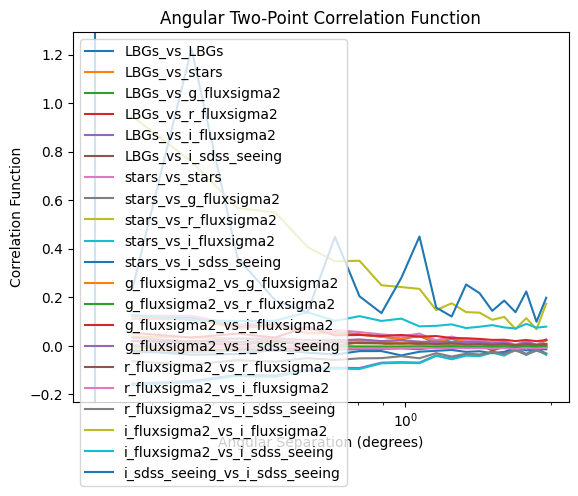

In [6]:
w ={}
for i, _, _, nm1, nm2, twopt_name in twopt_iter():
    print(twopt_name)
    m1 = maps[nm1]
    m2 = maps[nm2]
    start = time.perf_counter()
    print('computing %s corr. func. '%twopt_name)
    w[twopt_name] = get_twopt_corr(theta_bins, m1,m2, weight, nside)
    end = time.perf_counter()
    print('computation finshed in %e sec. '%(end-start))
    theta_mid = 0.5 * (theta_bins[1:] + theta_bins[:-1])
    plt.plot(np.degrees(theta_mid), w[twopt_name], label = twopt_name)

# Plot the correlation function
plt.axvline(theta_pix)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Angular Separation (degrees)')
plt.ylabel('Correlation Function')
plt.title('Angular Two-Point Correlation Function')
plt.legend()
plt.show()

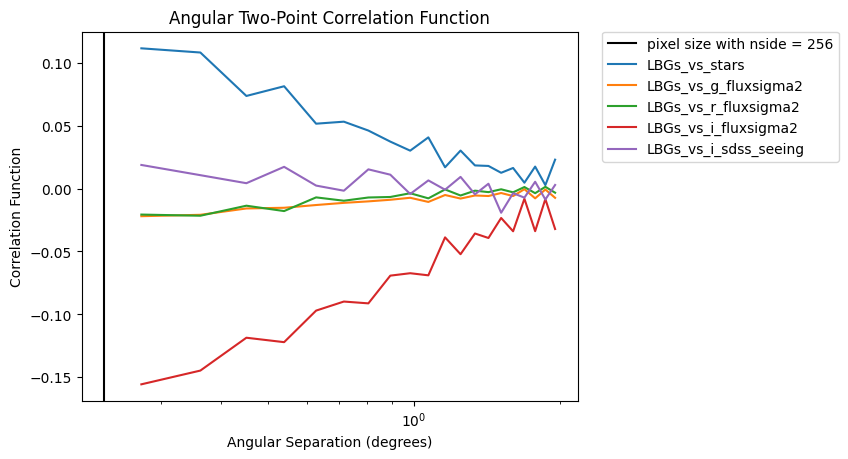

In [7]:
# cross corr. with LBGs
plt.axvline(theta_pix, color='black', label='pixel size with nside = %d'%nside)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Angular Separation (degrees)')
plt.ylabel('Correlation Function')
theta_mid = 0.5 * (theta_bins[1:] + theta_bins[:-1])
plt.plot(np.degrees(theta_mid), w['LBGs_vs_stars'], label = 'LBGs_vs_stars')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_g_fluxsigma2'], label = 'LBGs_vs_g_fluxsigma2')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_r_fluxsigma2'], label = 'LBGs_vs_r_fluxsigma2')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_i_fluxsigma2'], label = 'LBGs_vs_i_fluxsigma2')
plt.plot(np.degrees(theta_mid), w['LBGs_vs_i_sdss_seeing'], label = 'LBGs_vs_i_sdss_seeing')
plt.title('Angular Two-Point Correlation Function')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=10)
plt.show()